<img src="images/OFE-color-horizontal.png" width="300"> 

# MDAnalysis 2025: Exploring MCL-1 fragment RBFEs using OpenFE

## Introduction

The OpenFE ecosystem is an open-source framework for calculating alchemical free energies.


Binding free energies are one metric used to predict which ligand might bind best to a target protein and are often used in **computational drug discovery campaigns**.

This notebook demonstrates how you can use openfe's Python API to execute physics-based simulations and calculate relative binding free energies (RBFEs) for a series of ligands and a protein. 


Specifically, we will cover:
* Loading and defining systems
* Atom mapping and network creation
* Creating & running RBFE simulations
* Analyzing free energy results


## Background

<img src="images/rbfe_thermocycle.png" width="450"/>

### Alchemical Transformations


Each edge of the network is an ***alchemical*** transformation.

We use the term "alchemical" because these calculations rely on the non-physical operation of transforming one segment of the molecule (green) into another segment (blue) by gradually turning the green segments' interactions off while turning the blue segments' interactions on. 

<center> <img src="images/lambda_windows.png" width="600"> </center>

For an RBFE calculation, the ligands in our series of candidates must be represented as a **network** that relates the molecules to each other.

<center><img src="images/model_network.png" width="500"/></center>

### RBFE Workflow Overview

OpenFE RBFE calculations can be thought of as 3 distinct steps:

 1. **Setup**: construct a graph relating the ligands
 2. **Run**: execute a physics-based simulation
 3. **Gather**: compute meaningful metrics from the simulation data

Each stage is supported by the OpenFE software packages, but everything can be accessed from the base openfe package, either through the **openfe CLI** or **openfe API**.


**NOTE**: OpenFE's RBFE protocol uses [OpenMM](https://openmm.org/) as the physics based simulation engine.

The workflow will walk you through how to execute Relative Binding Free Energy calculations to evaluate the candidate ligands and produce a table like the one shown on the right:

<center><img src="images/RBFE_overview.png"/></center>

| **Step** | **External Tooling Used** |
|:---------|:----------------|
| 1. Creating OpenFE Components | RDKit, OpenMM, OpenFF |
| 2. Generating Atom Mappings | Kartograf, RDKit |
| 3. Creating a Ligand Network | Lomap, Networkx |
| 4. Defining a network of RBFE Alchemical Transformations | |
| 5. Running the simulations | OpenMM, OpenMMTools, Perses, OpenFF |
| 6. Gathering results | OpenMMTools, PyMBAR |
| 7. Analysis | Cinnabar, Matplotlib |


### Test case: MCL-1 Fragments

* A set of **14 fragment** elaborations from a screen by [Friberg et al., J. Med Chem. 2013](https://pmc.ncbi.nlm.nih.gov/articles/PMC3646517/).

* Part of the FEP+ fragment study by [Steinbrecher et al. J. Chem. Inf. Model 2015](https://pubs.acs.org/doi/10.1021/acs.jcim.7b00564)

<img src="images/mcl1_frag_elaboration.png" width="350"/><img src="images/mcl1_site.png" width="300"/>

First, use rdkit to visualize the candidate ligands:

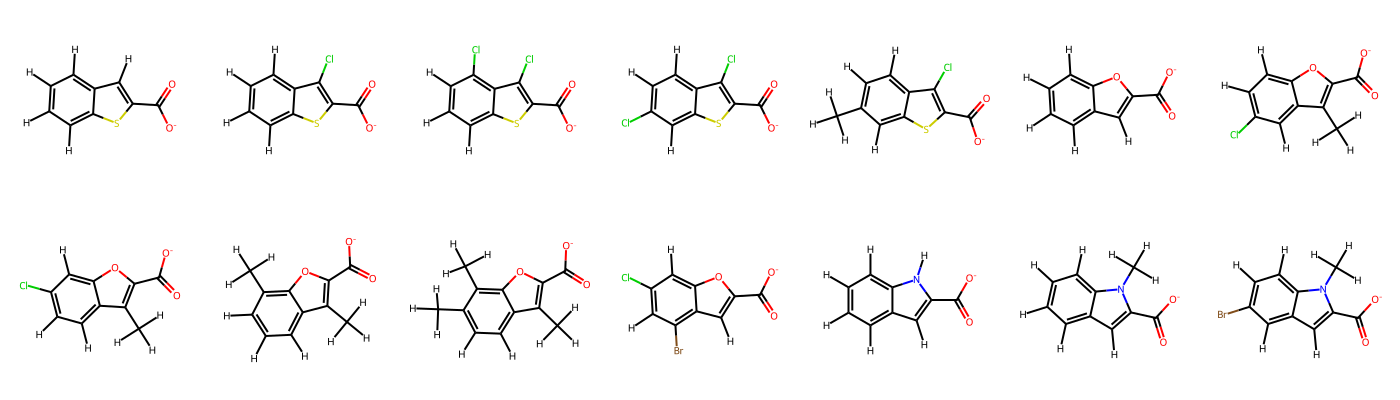

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

# Extract SDF contents, generate 2D coords (note: non-aligned scaffold!)
ligand_rdmols = [m for m in Chem.SDMolSupplier('inputs/ligands.sdf', removeHs=False)]
[AllChem.Compute2DCoords(ligand) for ligand in ligand_rdmols]

Chem.Draw.MolsToGridImage(ligand_rdmols, molsPerRow=7)

## 1 a) Setup: Creating OpenFE Components

The simulations in this study will contain the following components:

- [protein](https://docs.openfree.energy/en/v1.7.0/reference/api/generated/openfe.ProteinComponent.html): MCL1
- [solvent](https://docs.openfree.energy/en/v1.7.0/reference/api/generated/openfe.SolventComponent.html): water + NaCl
- [small molecule](https://docs.openfree.energy/en/v1.7.0/reference/api/generated/openfe.SmallMoleculeComponent.html): one of the 14 ligands shown above



<img src="images/OpenFEComponents.png"/>

In [2]:
import openfe
from openff.units import unit

# ProteinComponent
protein = openfe.ProteinComponent.from_pdb_file('inputs/protein.pdb', name="MCL1")

# SolventComponent
solvent = openfe.SolventComponent(
    positive_ion='Na', negative_ion='Cl',
    neutralize=True,
    ion_concentration=0.15*unit.nanomolar
)

# Ligands
ligand_mols = [
    openfe.SmallMoleculeComponent(sdf)
    for sdf in Chem.SDMolSupplier(
        'inputs/ligands.sdf', removeHs=False
    )
]

Take a moment to inspect the components you just created.

In [3]:
protein
# protein.smiles
# protein.total_charge

ProteinComponent(name=MCL1)

In [4]:
solvent
# solvent.ion_concentration
# solvent.positive_ion
# solvent.negative_ion

SolventComponent(name=O, Na+, Cl-)

In [5]:
ligand_mols
# ligand_1 = ligand_mols[0]
# ligand_1.smiles

[SmallMoleculeComponent(name=ligand_1),
 SmallMoleculeComponent(name=ligand_2),
 SmallMoleculeComponent(name=ligand_3),
 SmallMoleculeComponent(name=ligand_4),
 SmallMoleculeComponent(name=ligand_5),
 SmallMoleculeComponent(name=ligand_6),
 SmallMoleculeComponent(name=ligand_7),
 SmallMoleculeComponent(name=ligand_8),
 SmallMoleculeComponent(name=ligand_9),
 SmallMoleculeComponent(name=ligand_10),
 SmallMoleculeComponent(name=ligand_11),
 SmallMoleculeComponent(name=ligand_12),
 SmallMoleculeComponent(name=ligand_13),
 SmallMoleculeComponent(name=ligand_14)]

## 1 b) Setup: Generating Atom Mappings

An atom mapping defines the atoms to be mutated - and _how_ those atoms will be mutated - during the alchemical transformation.

In **openfe** we currently have two atom mappers:
1. [LomapAtomMapper](https://pmc.ncbi.nlm.nih.gov/articles/PMC3837551/) (Minimum Common Structure based)

2. [KartografAtomMapper](https://pmc.ncbi.nlm.nih.gov/articles/PMC10941767/) (Geometry-based)

You can use **openfe** to visualize atom mappings. The following color-coding is used:

* Uncolored atoms: elements identical in both structures
* Blue atoms: elements that are being mutated during the transformation
* Red atoms: endstate dummy atoms that do not have a corresponding atom in the corresponding end-state

Note that we do not map hydrogens here, so hydrogens will be shown in red. Note how the mapping visualization changes if you set `



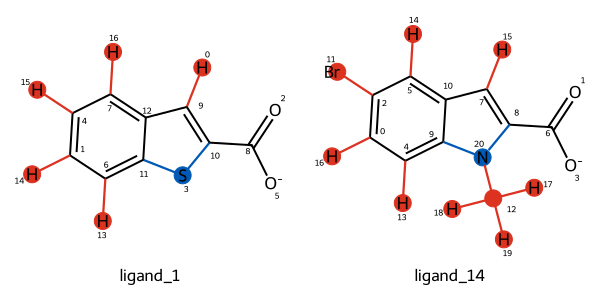

In [6]:
from kartograf import KartografAtomMapper

# initialize the kartograf atom mapper, try setting
# `atom_map_hydrogens=True`
mapper = KartografAtomMapper(atom_map_hydrogens=False)

# generate an atom mapping for the first and last molecules
atom_mapping = next(
    mapper.suggest_mappings(
        ligand_mols[0], ligand_mols[-1]
    )
)

atom_mapping

In [7]:
# TODO: add cookbook about atom mapper

We can also visualize the mappings in 3D!

*Note: atoms that have the same sphere color in both end states are mapped (i.e. will be transformed into dummy atoms in the opposite end state), while those without spheres are unmapped!*

In [8]:
from openfe.utils import visualization_3D

atom_mapping.view_3d(show_atomIDs=True)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## 1c) Setup: Creating a Ligand Network

<!-- We can use a mapper and a mapping scorer (e.g. `default_lomap_score`) to generate networks relating our ligands of interest. -->


For RBFE calculations, we must define the candidate ligands *in relation to one another*, since all of the binding free energies are defined as *relative* quantities.

A `LigandNetwork` is a network where each edge is an `AtomMapping` and each node is a `SmallMoleculeComponent`

It can be non-trivial to choose an optimal network generation algorithm. Ideally, you would choose to have as few edges as possible. However, if a calculation fails, you will loose the ability to rank entire ligand. In practice, it is recommended to introduce some redundancy in the form of additional edges into your network.

<img src="images/network_layouts.png" width="900"/>



OpenFE makes it simple to try different network algorithms, including:
* Minimum Spanning Tree networks (MST)
* LOMAP networks
* Star (or "radial") networks
* Loading external networks (e.g. FEP+)
* And many more using [konnektor](https://konnektor.openfree.energy/en/latest/guide/network_planner.html)!

In [9]:
from openfe.setup.ligand_network_planning import (
    generate_lomap_network,
    generate_minimal_spanning_network,
    generate_radial_network,
)
from openfe import lomap_scorers
# import logging
# logger = logging.getLogger()
# logger.setLevel(logging.CRITICAL)
# Create a mapper to use to generate the mappings that will be each edge
kartograf_mapper = KartografAtomMapper()

# Create a Lomap network
lomap_network = generate_lomap_network(
    ligands=ligand_mols,
    scorer=lomap_scorers.default_lomap_score,
    mappers=kartograf_mapper,
)

# Create an MST network
mst_network = generate_minimal_spanning_network(
    ligands=ligand_mols,
    scorer=lomap_scorers.default_lomap_score,
    mappers=kartograf_mapper,
)

# Create a star network
star_network = generate_radial_network(
    central_ligand=ligand_mols[0],  # use the first ligand as the central "hub"
    ligands=ligand_mols[:-1],
    mappers=kartograf_mapper,
)

INFO:root:Trying to remove edge 2-13 with similarity 0.637628
INFO:root:Checking edge deletion on distance-to-actives 0 vs 0
INFO:root:Removed edge 2-13
INFO:root:Trying to remove edge 3-13 with similarity 0.637628
INFO:root:Checking edge deletion on distance-to-actives 0 vs 0
INFO:root:Removed edge 3-13
INFO:root:Trying to remove edge 4-13 with similarity 0.637628
INFO:root:Checking edge deletion on distance-to-actives 0 vs 0
INFO:root:Removed edge 4-13
INFO:root:Trying to remove edge 7-13 with similarity 0.637628
INFO:root:Checking edge deletion on distance-to-actives 0 vs 0
INFO:root:Removed edge 7-13
INFO:root:Trying to remove edge 8-13 with similarity 0.637628
INFO:root:Checking edge deletion on distance-to-actives 0 vs 0
INFO:root:Removed edge 8-13
INFO:root:Trying to remove edge 9-12 with similarity 0.637628
INFO:root:Checking edge deletion on distance-to-actives 0 vs 0
INFO:root:Removed edge 9-12
INFO:root:Trying to remove edge 10-13 with similarity 0.637628
INFO:root:Checking 

You can see that, by constructing these networks, you've generated atom mappings that serve as the edges of the networks:

atom mapping:  {13: 14, 14: 15, 15: 16, 16: 12, 0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 13}


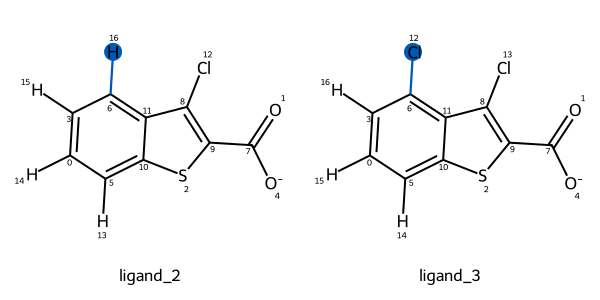

In [10]:
mst_edges = [edge for edge in mst_network.edges]

print("atom mapping: ", mst_edges[0].componentA_to_componentB)

mst_edges[0]

Now we can take a look at the 3 networks we've generated

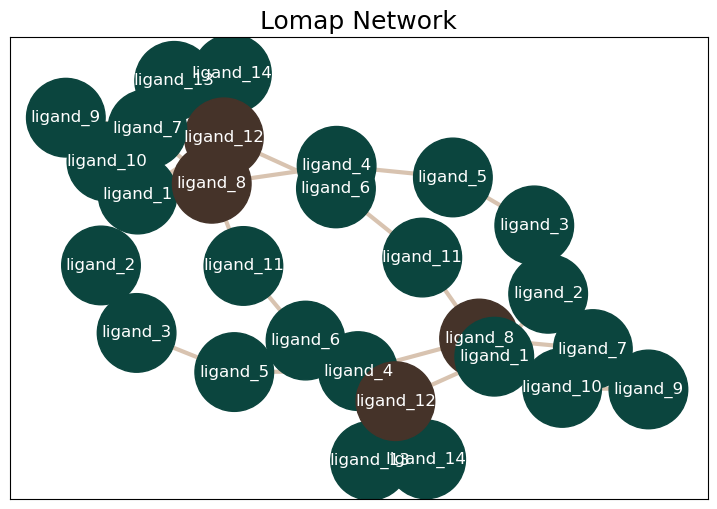

In [11]:
from konnektor.visualization import draw_ligand_network, draw_network_widget
import matplotlib.pyplot as plt
fig, ax =  plt.subplots(figsize=(9,6))
draw_ligand_network(lomap_network, node_size=3200, ax=ax, title="Lomap Network")
draw_ligand_network(lomap_network, node_size=3200, ax=ax, title="Lomap Network")

now let's see how this differs from a MST (minimal spanning tree) network:

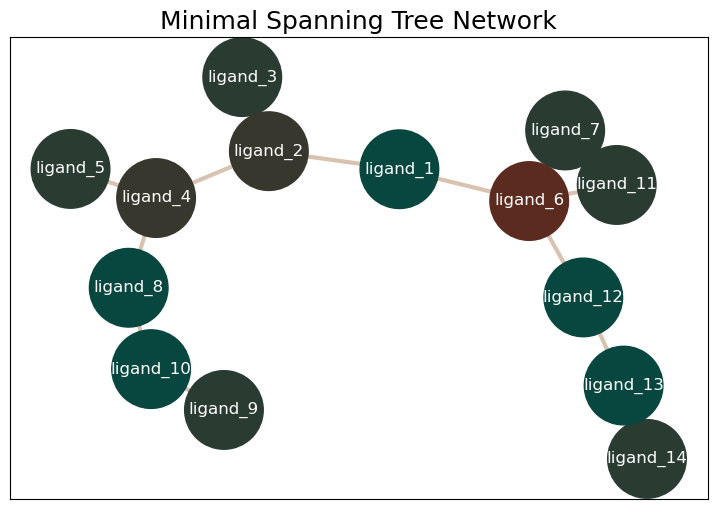

In [12]:
fig, ax =  plt.subplots(figsize=(9,6))
draw_ligand_network(mst_network, node_size=3200, ax=ax, title="Minimal Spanning Tree Network")

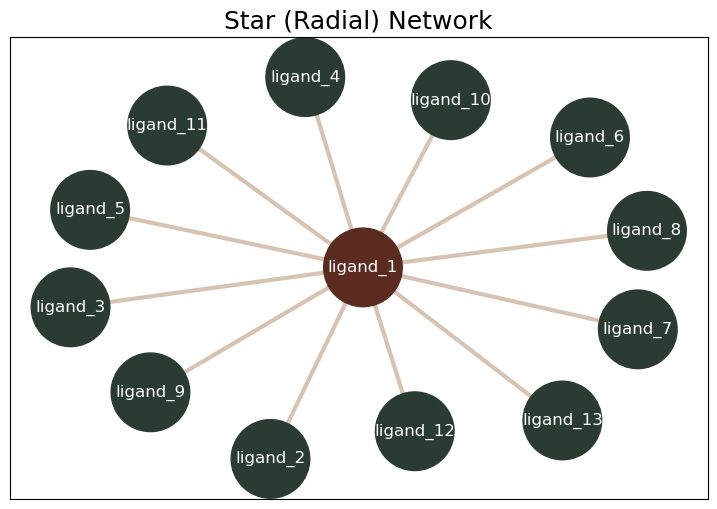

In [13]:
fig, ax =  plt.subplots(figsize=(9,6))
draw_ligand_network(star_network, node_size=3200, ax=ax, title="Star (Radial) Network")

Which of these networks:
- Require the fewest simulations?
- Contain a cycle?
- Are the most robust to a node failure?

**konnketor** also comes with a widget for interactive exploration:

In [14]:
widget = draw_network_widget(lomap_network)

interactive(children=(Dropdown(description='layout', index=4, options=('dagre', 'cola', 'breadthfirst', 'conce…

## 1d) Setup: Defining a Network of RBFE Alchemical Transformations

### Creating an RBFE cycle

For each edge (mapping) in our ligand network, we can define a set of simulations to allow us to calculate the **binding free energy**, $\Delta\Delta G$.

To do this we need to define:
  - 2 solvent states (shown on the left)
  - 2 complex states (shown on the right)
  - A state transformation simulation protocol

<img src="images/rbfe_thermocycle.png" width="400"/>

### Defining end states

`ChemicalSystems` are objects that store the individual `Component`s can be defined for each end-state of the cycle.

Free energy Protocols take in multiple `ChemicalSystems` to define the transformation being simulated.

In [15]:
# Selecting a specific edge
edge = mst_edges[0]

# Components are collated into ChemicalSystems

# Create the solvent legs
ligand_A_solvent = openfe.ChemicalSystem({'ligand': edge.componentA, 'solvent': solvent})
ligand_B_solvent = openfe.ChemicalSystem({'ligand': edge.componentB,'solvent': solvent})

# Create the complex legs
ligand_A_complex = openfe.ChemicalSystem({'ligand': edge.componentA, 'protein': protein, 'solvent': solvent})
ligand_B_complex = openfe.ChemicalSystem({'ligand': edge.componentB, 'protein': protein, 'solvent': solvent})



In [16]:
ligand_A_complex

ChemicalSystem(name=, components={'ligand': SmallMoleculeComponent(name=ligand_2), 'protein': ProteinComponent(name=MCL1), 'solvent': SolventComponent(name=O, Na+, Cl-)})

In [17]:
# We can inspect the equality of these ChemicalSystems to identify differences

copy_of_ligand_A_complex = openfe.ChemicalSystem(
    {'ligand': edge.componentA,
     'protein': protein,
     'solvent': solvent}
)
# these Chemical Systems are identical
print(ligand_A_complex == copy_of_ligand_A_complex)

# these Chemical systems are different
print(ligand_A_complex == ligand_B_complex)

True
False


### Creating a simulation Protocol

An OpenFE **Protocol** defines how a simulation will take place.

Here we use the `RelativeHybridTopologyProtocol`, based on Perses, which:
  * Uses a hybrid topology approach
  * Allows for equilibrium samplers; HREX, SAMS, and independent windows
  * Uses OpenMM as a simulation engine

Unlike ``Components``, you can mutate settings objects:

In [18]:
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

# Protocols require settings, and each has a default set
settings = RelativeHybridTopologyProtocol.default_settings()

# We can get the FF version
print(settings.forcefield_settings.small_molecule_forcefield)

# We can set the FF version
settings.forcefield_settings.small_molecule_forcefield = 'openff-2.2'
print(settings.forcefield_settings.small_molecule_forcefield)

openff-2.2.1
openff-2.2


In [19]:
settings.alchemical_settings

{'endstate_dispersion_correction': False,
 'explicit_charge_correction': False,
 'explicit_charge_correction_cutoff': {'unit': 'nanometer', 'val': 0.8},
 'softcore_LJ': 'gapsys',
 'softcore_alpha': 0.85,
 'turn_off_core_unique_exceptions': False,
 'use_dispersion_correction': False}


* **Protocol** objects are created from their settings and are immutable.

* **Protocol** objects define how to apply a Transformation to a set of input ChemicalSystems & atom mappings.

* **Protocol** objects can be re-used to define multiple simulations.

In [20]:
# Creating a Protocol for our RBFE simulations

rbfe_protocol = RelativeHybridTopologyProtocol(
    settings=settings
)

### Creating the Transformations

With `ChemicalSystem`s and a `Protocol` defined, we can create a set of `Transformation`s for our RBFE cycle.

A `Transformation` contains everything necessary to run a single simulation. For our chosen RFE Protocol this requires:
  * Two `ChemicalSystem` defining the end states
  * An atom mapping between the transforming ligands
  * A `Protocol` object
  * A name (optional)

### Constructing Networks of Transformations (AlchemicalNetworks)

Repeat the process of creating complex and solvent tranformations for an edge for all the edges in our ``LigandNetwork``.


In [21]:
transformations = []
for mapping in mst_network.edges:
    for leg in ['solvent', 'complex']:
        # use the solvent and protein created above
        sysA_dict = {'ligand': mapping.componentA, 'solvent': solvent}
        sysB_dict = {'ligand': mapping.componentB, 'solvent': solvent}

        # complex legs include a protein, solvent legs do not
        if leg == 'complex':
            sysA_dict['protein'] = protein
            sysB_dict['protein'] = protein

        # create the systems of both end-states
        sysA = openfe.ChemicalSystem(sysA_dict)
        sysB = openfe.ChemicalSystem(sysB_dict)

        # define a useful name
        name = (f"{leg}_{mapping.componentA.name}_{mapping.componentB.name}")

        # create the transformation between state A and state B
        transformation = openfe.Transformation(
            stateA=sysA,
            stateB=sysB,
            mapping=mapping,
            protocol=rbfe_protocol,
            name=name
        )
        transformations.append(transformation)



From this list of transformations, we can create an `AlchemicalNetwork`, which contain all the `Transformation` for all the simulations necessary for a network of RBFE calculations.
An ``AlchemicalNetwork`` can be a useful object execution, such as if you use alchemiscale, but we won't be performing simulations in this workshop.

In [79]:
network = openfe.AlchemicalNetwork(transformations)

In [81]:
# Similarly we can write out all the AlchemicalNetwork
# Transformations to disk

# first we create the directory
transformation_dir = pathlib.Path("networktransforms")
transformation_dir.mkdir(exist_ok=True)

# then we write out each transformation
for transformation in network.edges:
    transformation.to_json(transformation_dir / f"{transformation.name}.json")

In [85]:
!ls networktransforms

complex_ligand_1_ligand_1.json   solvent_ligand_1_ligand_1.json
complex_ligand_12_ligand_12.json solvent_ligand_12_ligand_12.json
complex_ligand_13_ligand_13.json solvent_ligand_13_ligand_13.json
complex_ligand_2_ligand_2.json   solvent_ligand_2_ligand_2.json
complex_ligand_4_ligand_4.json   solvent_ligand_4_ligand_4.json
complex_ligand_6_ligand_6.json   solvent_ligand_6_ligand_6.json
complex_ligand_8_ligand_8.json   solvent_ligand_8_ligand_8.json
complex_ligand_9_ligand_9.json   solvent_ligand_9_ligand_9.json


/Users/atravitz/micromamba/envs/openff-openfe-demo/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=51379) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


## 5. Running simulations

We can run each leg of our simulation using the `quickrun` command on each of the transformations we created above.

Often, you would be able to iterate on the "Planning" stage locally, then transfer just the transformation JSON files (the contents of `networktransforms/` above) to an HCP, then run `openfe quickrun` within a submission script (such as a SLURM script).

This takes one of the JSON files we wrote, runs the simulation, and writes an output JSON file with the simulation results.

``` bash
openfe quickrun path/to/transformation.json -o results.json -d working-directory

```

You can loop over a list of JSON files to run through a network, or distribute your `quickrun` commands over a HPC cluster.

**Note:** alternative execution engines can also be used, such as [Alchemiscale](https://alchemiscale.org).


## 6. Gathering Results

### Simulation analyses generated by openfe

Once complete, the `quickrun` command will create a results JSON file, and an accompanying directory with relevant simulation files.

We have just one directory for the example data, which would correspond to the transformation between ligand_12 and ligand_13 in the solvent phase:

The files within this directory include various structure (`.pdb`) and trajectory (`.nc`) files, and outputs from automated analyses.

First, we can view `mbar_overlap_matrix.png` and `replica_exchange_matrix.png`:

<img src="results_demo/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-be5ac08159a948f58c5b40195b7c777c_attempt_0/mbar_overlap_matrix.png" width="500"/> <img src="results_demo/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-be5ac08159a948f58c5b40195b7c777c_attempt_0/replica_exchange_matrix.png" width="500"/>

`forward_reverse_convergence.png`: using increasingly larger portions of the total data, this analysis calculates the free energy difference, both in forward and backward directions. In this analysis, forward and backward estimates that agree within error using only a fraction of the total data suggest convergence

<center><img src="results_demo/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-be5ac08159a948f58c5b40195b7c777c_attempt_0/forward_reverse_convergence.png" width="650"/></center>



`replica_state_timeseries.png`: time evolution of the different system configurations as they are exchanged between different lambda states. This plot should show that the states are freely mixing and that there are no cliques forming.

<center><img src="results_demo/easy_rbfe_ligand_12_solvent_ligand_13_solvent/shared_RelativeHybridTopologyProtocolUnit-be5ac08159a948f58c5b40195b7c777c_attempt_0/replica_state_timeseries.png" width="900"/></center>


### Structural Analysis

For systems with a protein present, there are additional analyses that may be helpful. You can read more about them in our [User Guide](https://docs.openfree.energy/en/latest/guide/protocols/relativehybridtopology.html#id14)

### Gathering results on the command line

We can use the `gather` method to extract results directly from our simulations.

Here we report the relative binding free energies for each ligand pair, where the estimates and uncertainty are the average and standard deviation of three independent repeats.

In [33]:
!openfe gather results_demo/ --report ddg

/Users/atravitz/micromamba/envs/openff-openfe-demo/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=238) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


┌───────────┬───────────┬──────────────────────┬────────────────────────┐
│ ligand_i  │ ligand_j  │ DDG(i->j) (kcal/mol) │ uncertainty (kcal/mol) │
├───────────┼───────────┼──────────────────────┼────────────────────────┤
│ ligand_1  │ ligand_2  │ -2.9                 │ 0.2                    │
│ ligand_1  │ ligand_6  │ 0.5                  │ 0.3                    │
│ ligand_12 │ ligand_13 │ -1.4                 │ 0.1                    │
│ ligand_13 │ ligand_14 │ -0.2                 │ 0.2                    │
│ ligand_2  │ ligand_3  │ -1.42                │ 0.06                   │
│ ligand_2  │ ligand_4  │ -0.43                │ 0.08                   │
│ ligand_4  │ ligand_5  │ 0.7                  │ 0.1                    │
│ ligand_4  │ ligand_8  │ 0.4                  │ 0.2                    │
│ ligand_6  │ ligand_11 │ -2.27                │ 0.10                   │
│ ligand_6  │ ligand_12 │ 0.65                 │ 0.07                   │
│ ligand_6  │ ligand_7  │ -1.9        

There is also an option to get the absolute free energies using Maximum Likelihood Estimation with the [cinnabar](https://github.com/OpenFreeEnergy/cinnabar) toolkit.

In [34]:
!openfe gather results_demo/ --report dg

/Users/atravitz/micromamba/envs/openff-openfe-demo/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=238) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


┌───────────┬────────────────────┬────────────────────────┐
│ ligand    │ DG(MLE) (kcal/mol) │ uncertainty (kcal/mol) │
├───────────┼────────────────────┼────────────────────────┤
│ ligand_1  │ 1.7                │ 0.2                    │
│ ligand_2  │ -1.2               │ 0.2                    │
│ ligand_6  │ 2.3                │ 0.2                    │
│ ligand_12 │ 2.9                │ 0.2                    │
│ ligand_13 │ 1.5                │ 0.2                    │
│ ligand_14 │ 1.3                │ 0.3                    │
│ ligand_3  │ -2.6               │ 0.2                    │
│ ligand_4  │ -1.6               │ 0.2                    │
│ ligand_5  │ -0.8               │ 0.2                    │
│ ligand_8  │ -1.1               │ 0.3                    │
│ ligand_11 │ -0.0               │ 0.2                    │
│ ligand_7  │ 0.4                │ 0.2                    │
│ ligand_10 │ -1.2               │ 0.3                    │
│ ligand_9  │ -1.6               │ 0.3  

With a little bit of data wrangling with experimental results, and the use of the [cinnabar](https://github.com/OpenFreeEnergy/cinnabar) toolkit, we can plot these results out.

By comparison, the 2015 Steinbrecher et al. study yielded very similar results with within error RMSE and R2 values.

<img src="images/mcl1_exp_DDG.png"/> <img src="images/mcl1_exp_DG.png"/>